In [1]:
# Copyright (c) Facebook, Inc. and its affiliates.
# All rights reserved.
#
# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
#
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ..

from matplotlib.pylab import plt
from multiprocessing import Pool
import itertools
import numpy as np
import torch
from foltr.data.datasets import MqDataset
from foltr.client.click_simulate import NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL
from foltr.client.metrics import PrivatizedMaxRR
from foltr.click_optimize import train_uniform
from foltr.client.rankers import LinearRanker, TwoLayerRanker

seed = 7
torch.manual_seed(seed)
np.random.seed(seed)

all_click_models = [NAVIGATIONAL_MODEL, INFORMATIONAL_MODEL, PERFECT_MODEL]

In [2]:
data = MqDataset.from_path("./data/MQ2007/", "./cache/")

Cached the array to ././cache//51f3f297774a6b4f6b2ba8f09a067395.pkl
Cached the array to ././cache//d8c769a90101f407935141adf73f446a.pkl
Cached the array to ././cache//c254c204287eb73e457b5c1502fef110.pkl
Cached the array to ././cache//d3bf468324b060a8c32c2abc1a7c9007.pkl
Cached the array to ././cache//afd404899cd63a45bbc0bbb746f0adad.pkl
Cached the array to ././cache//6b42f1207bc836b4b360a6cca9d175d2.pkl
Cached the array to ././cache//32085d34b138ade9b25b14ec2d85311c.pkl
Cached the array to ././cache//53f10952856498e3536c29c506df07b6.pkl
Cached the array to ././cache//16f628eaf4ac373ee0058b62b9cc503a.pkl
Cached the array to ././cache//7d828b414b547c72c97fa16e43ca20f1.pkl
Cached the array to ././cache//fcb8cabdbc0865259a9b9adfcbfa60fe.pkl
Cached the array to ././cache//823cae02167126f06352ad24b8873195.pkl
Cached the array to ././cache//22c6fa1e6d257d8385dc774fd7f44d73.pkl
Cached the array to ././cache//2ceb82b3956ccc66d6c4d10cfb4e2576.pkl
Cached the array to ././cache//deb1c0d9c992d8cba

In [3]:
ranker_generator = lambda: LinearRanker(46)
common_params = dict(online_metric=PrivatizedMaxRR(1.0),
                     n_clients=2000,
                     sessions_budget=1000000, 
                     seed=seed,
                     ranker_generator=ranker_generator,
                     sessions_per_feedback=4,
                     noise_std=1e-2, lr=1e-3)

antithetic_grid = [True, False]
validation = data.folds[0].validation

def get_trajectory(task):
    antithetic, click_model = task
    
    params = common_params.copy()
    params.update(dict(antithetic=antithetic, click_model=click_model))
    train_result = train_uniform(params, validation)
    return train_result.batch_metrics

tasks = itertools.product(antithetic_grid, all_click_models)
tasks = list(tasks)
n_cpu = min(80, len(tasks))

with Pool(n_cpu) as p:
    trajectories = p.map(get_trajectory, tasks)
    
click_model2trajectory = dict((m.name, {}) for m in all_click_models)
for (antithetic, click_model), results in zip(tasks, trajectories):
    click_model2trajectory[click_model.name][antithetic] = results

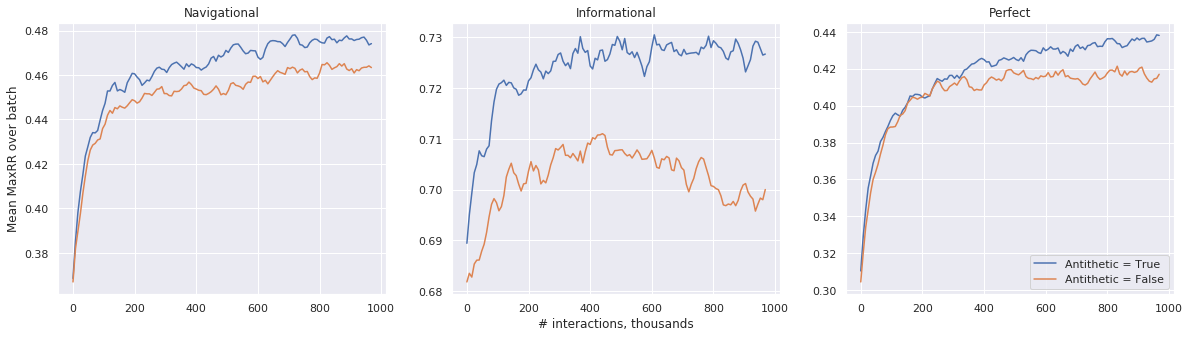

In [4]:
from util import smoothen_trajectory
import seaborn as sns
sns.set(style="darkgrid")
from pylab import rcParams
plt.close('all')
rcParams['figure.figsize'] = 20, 5

f, ax = plt.subplots(1, 3)

for model_id, model_name in enumerate([m.name for m in all_click_models]):
    for i, p in enumerate(antithetic_grid):
        trajectory = click_model2trajectory[model_name][p]
        trajectory = smoothen_trajectory(trajectory, group_size=4)
        xs = np.array(range(len(trajectory))) * common_params['n_clients'] * common_params['sessions_per_feedback'] * 1e-3 
        ax[model_id].plot(xs, trajectory, label=f"Antithetic = {p}")
        ax[model_id].set_title(model_name)
ax[2].legend(loc="lower right")
ax[0].set_ylabel("Mean MaxRR over batch")
ax[1].set_xlabel("# interactions, thousands")

plt.show()
f.savefig('antithetic.png')